# Домашняя работа 2

In [187]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, SGDRegressor, HuberRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures

## Подготовка данных

Будем использовать датасет mstz/abalone, содержащий информацию о морских моллюсках. Предсказывать будем возраст моллюска (`number_of_rings`)

Из [документации по датасету](https://archive-beta.ics.uci.edu/dataset/1/abalone) знаем, что числовые признаки уже были масштабированы делением на 200, а строки с пропусками удалены

In [188]:
df = pd.read_csv("hf://datasets/mstz/abalone/abalone/train.csv")
df.head()

,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,number_of_rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sex              4177 non-null   object 
 1   length           4177 non-null   float64
 2   diameter         4177 non-null   float64
 3   height           4177 non-null   float64
 4   whole_weight     4177 non-null   float64
 5   shucked_weight   4177 non-null   float64
 6   viscera_weight   4177 non-null   float64
 7   shell_weight     4177 non-null   float64
 8   number_of_rings  4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [190]:
df.describe()

,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,number_of_rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Видим, что пропусков действительно нет

In [191]:
df.isna().sum()

sex                0
length             0
diameter           0
height             0
whole_weight       0
shucked_weight     0
viscera_weight     0
shell_weight       0
number_of_rings    0
dtype: int64

У нас есть одна категориальная переменная. Закодируем ее

In [192]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop('number_of_rings', axis=1),
    df['number_of_rings'],
    random_state=1,
    test_size=0.4,
)

X_test, X_val, y_test, y_val = train_test_split(
    X_test,
    y_test,
    random_state=1,
    test_size=0.5,
)

In [193]:
X_train.shape

(2506, 8)

In [194]:
X_test.shape

(835, 8)

In [195]:
X_val.shape

(836, 8)

## Бейзлайны

In [196]:
y_pred_mean = np.full(y_test.shape, y_test.mean())
y_pred_median = np.full(y_test.shape, y_test.median())

Оба бейзлайна показывают ожидаемо низкие метрики: R² 0 и -0.2 (при идеальном значении равном 1), MAE и MSE у бейзлайнов практически одинаковые (тоже ожидаемо, так как среднее и медианное значение у целевой переменной близки). У обоиз бейзлайнов MSE выше, чем MAE, что говорит о

In [197]:
print_metrics(y_test, y_pred_mean, "Mean baseline")

Metrics for Mean baseline [test]:
MAE:	 2.29620
MSE:	 3.14839
R²:	 0.00000


In [198]:
print_metrics(y_test, y_pred_median, "Median baseline")

Metrics for Median baseline [test]:
MAE:	 2.29581
MSE:	 3.14842
R²:	 -0.00002


## Инструменты для анализа

Подготовим функции для подсчета метрик и построения графиков

In [240]:
metrics = []
train_metrics = []

In [241]:
def print_metrics(y_true, y_pred, model_name, dataset):
    mae = mean_absolute_error(y_true, y_pred)
    mse = math.sqrt(mean_squared_error(y_true, y_pred))
    r_2 = r2_score(y_true, y_pred)
    
    if dataset == "test":
        global metrics
        metrics.append((model_name, mae, mse, r_2))
    elif dataset == "train":
        global train_metrics
        train_metrics.append((model_name, mae, mse, r_2))
    
    print(f"Metrics for {model_name} [{dataset}]:")
    print(f"MAE:\t {mae:.5f}")
    print(f"MSE:\t {mse:.5f}")
    print(f"R²:\t {r_2:.5f}")

In [242]:
def plot_charts(y_true, y_pred, model_name):
    fig, ax = plt.subplots(1, 2, figsize=(25, 8))

    ax[0].scatter(x=y_true, y=y_pred, alpha=0.3)
    ax[0].set_xlabel("True value")
    ax[0].set_ylabel("Predicted value")
    ax[0].set_title(f"Prediction diagram for {model_name}")
    ax[0].plot(y_true, y_true, 'r')
    ax[0].grid(which="both")

    residuals = y_true - y_pred

    ax[1].scatter(x=y_pred, y=residuals, alpha=0.3)
    ax[1].plot(y_pred, np.zeros(y_true.shape), 'r')
    ax[1].set_xlabel("Predicted value")
    ax[1].set_ylabel("Residuals")
    ax[1].grid(which="both")
    ax[1].set_title(f"Residuals plot for {model_name}")

    plt.show()

## Предобработка данных

Подготвим пайплайн для предобработки данных:
- масштабирование числовых признаков (чтобы модель не считала бо́льшие по величине признаки более важными)
- кодирование категориальных (выразим $n$ нечисловых категорий в виде $n$ столбцов, принимающих значение 0 или 1)

In [243]:
numeric_cols = X_train.select_dtypes(include="number").columns
categorical_cols = X_train.select_dtypes(exclude="number").columns

preprocessor = ColumnTransformer(
    [
        ("scaler", StandardScaler(), numeric_cols),
        ("encoder", OneHotEncoder(), categorical_cols)
    ],
)

## Линейная регрессия

Построим модель линейной регресии для предсказания возраста моллюсков

In [244]:
linreg = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("linreg", LinearRegression()),
    ]
)

linreg.fit(X_train, y_train)

y_pred_val_linreg = linreg.predict(X_val)

In [245]:
print_metrics(y_train, linreg.predict(X_train), "Linear regression", "train")

Metrics for Linear regression [train]:
MAE:	 1.56630
MSE:	 2.17339
R²:	 0.54832


In [246]:
print_metrics(y_val, y_pred_val_linreg, "Linear regression", "val")

Metrics for Linear regression [val]:
MAE:	 1.56935
MSE:	 2.33837
R²:	 0.48774


In [247]:
y_pred_linreg = linreg.predict(X_test)

In [248]:
print_metrics(y_test, y_pred_linreg, "Linear regression", "test")

Metrics for Linear regression [test]:
MAE:	 1.59842
MSE:	 2.18286
R²:	 0.51930


In [249]:
metrics

[('Linear regression',
  1.5984203461984574,
  2.1828635245226504,
  0.5192964738095581)]

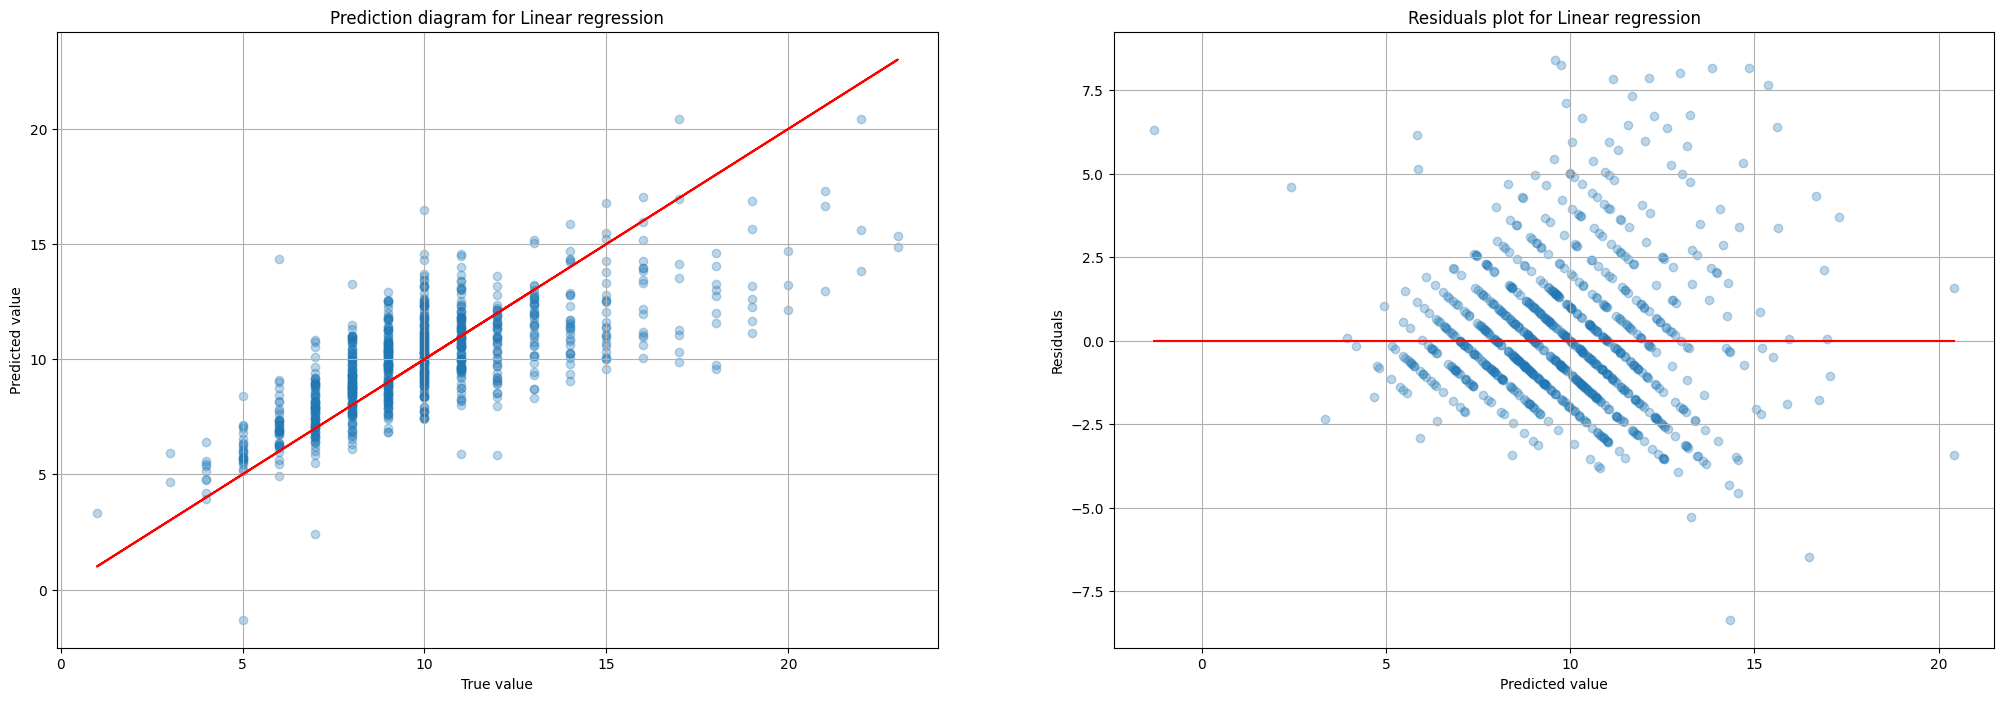

In [250]:
plot_charts(y_test, y_pred_linreg, "Linear regression")

### Анализ результатов линейной регресии

Видим достаточно низкие значения R² (около 0.5) для test и val датасетов. MAE ~1.5, то есть модель в среднем ошибается на 1.5 года (при среднем значении целевой переменной около 9.9)

Значения этих метрик вместе с графиками указывают нам на то, что данные не полностью нелинейны (линейная регрессия позволяет в некоторой мере выразить закономерность)

Однако график соответствия показывает, что начиная с определенного возраста (около 12-13 лет) моллюски замедляются в росте. Это же отражается на графике остатков: с увеличением значения целевой перемнной растет и дисперсия ошибок, что говорит нам о том, что в данных присутствует **гетероскедатичность** 

## SGD Regressor

Линейная регрессия обучается с функцией потерь MSE. Теперь попробуем обучить SGDRegressor с минимизацией MAE

In [251]:
sgd = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "sgd",
            SGDRegressor(
                loss="epsilon_insensitive",
                epsilon=1,
                penalty="l1",
                random_state=1,
                learning_rate="adaptive",
            )
        ),
    ]
)

sgd.fit(X_train, y_train)

y_pred_val_sgd = sgd.predict(X_val)

In [252]:
print_metrics(y_train, sgd.predict(X_train), "SGDRegressor (MAE)", "train")

Metrics for SGDRegressor (MAE) [train]:
MAE:	 1.54204
MSE:	 2.20887
R²:	 0.53345


In [253]:
print_metrics(y_val, y_pred_val_sgd, "SGDRegressor (MAE)", "val")

Metrics for SGDRegressor (MAE) [val]:
MAE:	 1.54244
MSE:	 2.34136
R²:	 0.48643


In [254]:
y_pred_sgd = sgd.predict(X_test)

In [255]:
print_metrics(y_test, y_pred_sgd, "SGDRegressor (MAE)", "test")

Metrics for SGDRegressor (MAE) [test]:
MAE:	 1.58959
MSE:	 2.22110
R²:	 0.50231


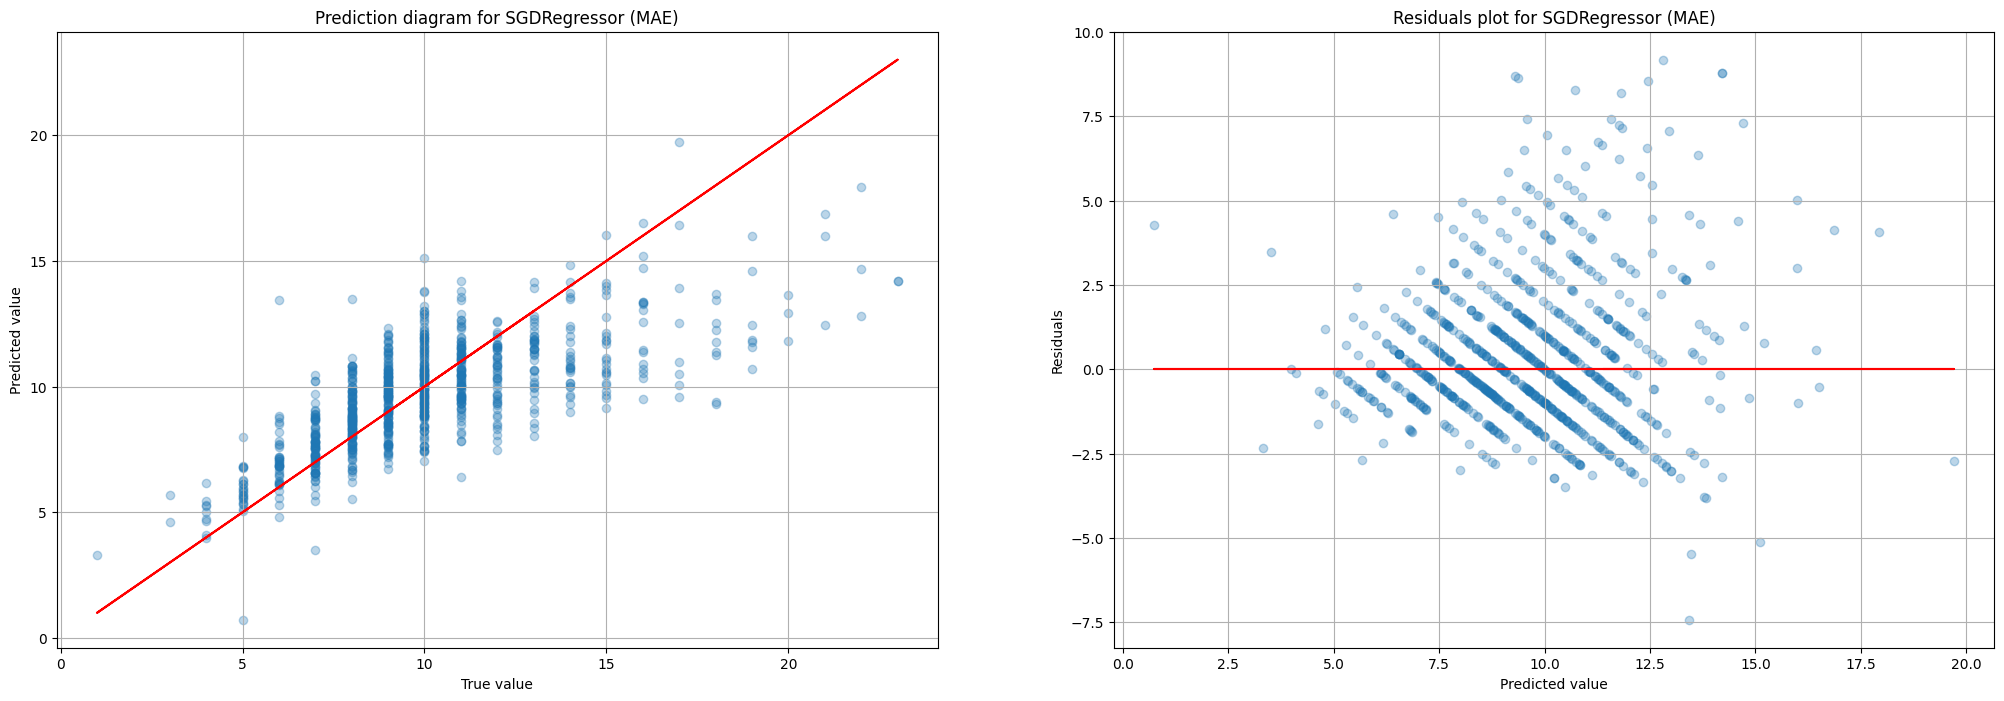

In [256]:
plot_charts(y_test, y_pred_sgd, "SGDRegressor (MAE)")

### Анализ результатов SGD Regressor с минимизацией MAE

Значения метрик для SGD Regressor вышли очень похожими на метрики линейной регрессии. Это говорит нам о том, что в данных нет сильных выбросов: минимизация MSE менее устойчива к ним, следовательно, если бы в данных были значительные выбросы, линейная регрессия показала бы результат хуже, чем SGD Regressor

## Дополнительная функция потерь: HuberRegressor

Попробуем также построить и обучить модель с минимизацией функции потерь Huber. За счет того, что эта функция [квадратична для малых значений, и линейна для больших значений](https://ru.wikipedia.org/wiki/Функция_потерь_Хубера), она более устойчива к выбросам

In [214]:
huber = Pipeline(
    [
        ("preprocessor", preprocessor),
        (
            "huber", 
            HuberRegressor(
                epsilon=1.85,
            )
        )
    ]
)

huber.fit(X_train, y_train)

y_pred_val_huber = huber.predict(X_val)

In [258]:
print_metrics(y_train, huber.predict(X_train), "HuberRegressor", "train")

Metrics for HuberRegressor [train]:
MAE:	 1.54522
MSE:	 2.18435
R²:	 0.54375


In [259]:
print_metrics(y_val, y_pred_val_huber, "HuberRegressor", "val")

Metrics for HuberRegressor [val]:
MAE:	 1.54528
MSE:	 2.32476
R²:	 0.49369


In [260]:
y_pred_huber = huber.predict(X_test)

In [261]:
print_metrics(y_test, y_pred_huber, "HuberRegressor", "test")

Metrics for HuberRegressor [test]:
MAE:	 1.58529
MSE:	 2.19477
R²:	 0.51404


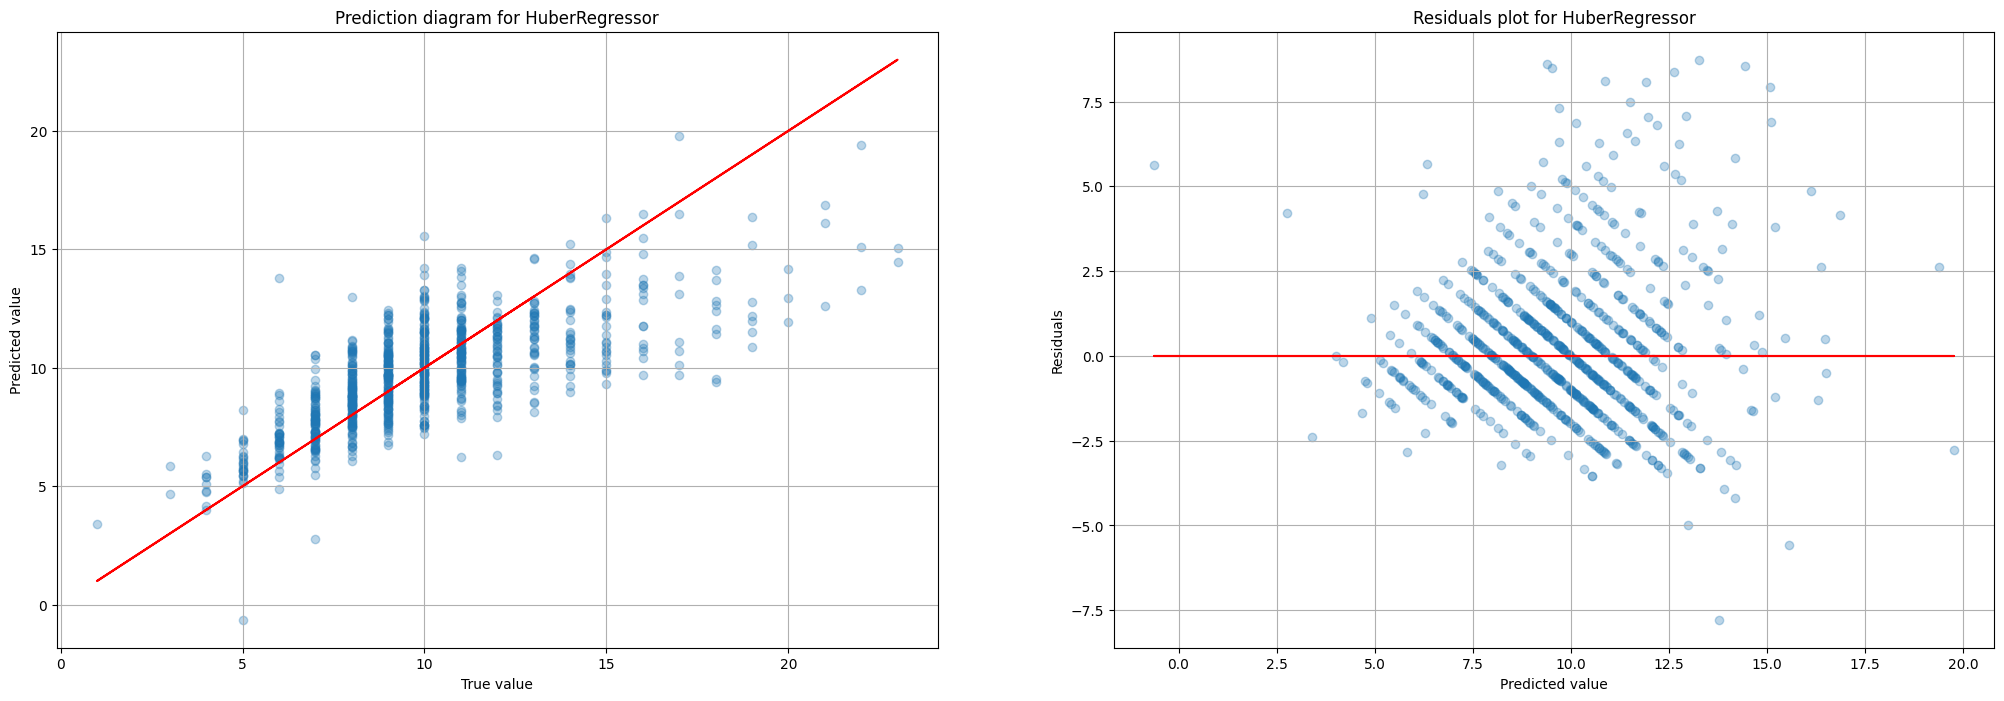

In [262]:
plot_charts(y_test, y_pred_huber, "HuberRegressor")

### Анализ результатов HuberRegressor

In [263]:
pd.DataFrame(metrics, columns=["model", "mae", "mse", "r_2"])

,model,mae,mse,r_2
0,Linear regression,1.598420,2.182864,0.519296
1,SGDRegressor (MAE),1.589593,2.221097,0.502310
2,HuberRegressor,1.585288,2.194774,0.514036


In [264]:
pd.DataFrame(train_metrics, columns=["model", "mae", "mse", "r_2"])

,model,mae,mse,r_2
0,Linear regression,1.566299,2.173386,0.548320
1,SGDRegressor (MAE),1.542036,2.208865,0.533453
2,HuberRegressor,1.545216,2.184353,0.543750


Видим похожую картину: значения метрик получились практически такими же, как и у предыдущих двух моделей. Это опять же говорит нам о том, что такие значения метрик обусловлены характером данных (а именно их гетероскедатичностью), а не ошибкой в выборе модели или функции потерь

Разница в метриках на тестовой и обучающей выборках достаточно маленькая, что говорит об устойчисовти моделей

Можем сделать вывод, что для этих данных одинаково хорошо подходит любая из проверенных метрик, если мы ограничиваемся линейными моделями

Однако для лучших результатов с этим датасетом следует использовать модели, умеющие выражать нелинейные зависимости в данных. Добиться более высоких результатов с помощью линейной регресии нам не позволяет гетероскедатичность